# **Politecnico di Milano**
## *Students: Caravano Andrea, Cantele Alberto*

*A.Y.: 2024/2025*

*Last modified: 20/03/2025*

### Description: Internet of Things: Challenge n. 1 - Energy consumption part: computations notebook

## Preliminary declarations

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import math

# Problem data definition and constants
# Specification formula (expected result = 18260 Joule)
Battery_capacity = 8260 % 5000 + 15000
milliBattery_capacity = Battery_capacity * 10**3

dutyCycle = 60 % 50 + 5  # Specification formula (expected result = 15 seconds)
dutyCycle_micros = dutyCycle * 10**6

T_wakeup = 1153364  # First measured value (see later) (from misurations.csv)
T_deepSleep = dutyCycle_micros  # Fixed time for deep sleep (a first approximation to the problem, see considerations in the report for more details)

# Results considered in the following
print("Duty cycle time: %.2f uS" % dutyCycle_micros)
print("Battery capacity: %.2f mJ" % milliBattery_capacity)

Duty cycle time: 15000000.00 uS
Battery capacity: 18260000.00 mJ


## Provided dataset analysis

In [2]:
# Load power consumption data for pandas from the CSV files (as a complementary to the specifications)
deepSleep_dataframe = pd.read_csv("datasets/deep_sleep.csv")
sensor_dataframe = pd.read_csv("datasets/sensor_read.csv")
transmission_dataframe = pd.read_csv("datasets/transmission_power.csv")
timeMisuration_dataframe = pd.read_csv("datasets/measurements.csv")

### A complete cycle (deep sleep, idle, Wi-Fi activation)

<Axes: title={'center': 'Deep Sleep with Interrupt (complete cycle)'}, xlabel='Timestamps (seconds)', ylabel='Consumption (mW)'>

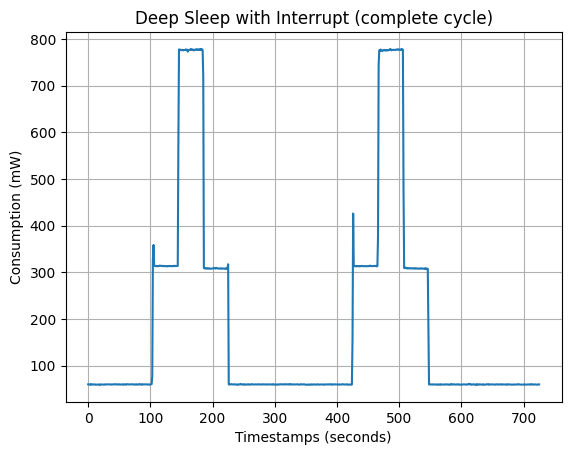

In [3]:
# Plot the deep_sleep consumption output (a complete cycle, as seen in the laboratory classes)
deepSleep_dataframe.plot(
    xlabel="Timestamps (seconds)",
    ylabel="Consumption (mW)",
    title="Deep Sleep with Interrupt (complete cycle)",
    kind="line",
    grid=True,
    legend=False,
)

In [4]:
# Idle power computation (just after the boot phase)
# Assumption: values are roughly between 300 and 350 (see the plot)
df = deepSleep_dataframe["Data"]
select_mean = df.loc[(df > 300) & (df < 350)].mean()
idlePower = select_mean.round(2)  # As usual, to deal with imprecision in approximation
print("Average consumption during idle phase: %.2f mW" % idlePower)

# Deep Sleep phase power computation (after the end of the cycle)
# Assumption: maximum average value is below 70 (by rounding, see the plot)
df = deepSleep_dataframe["Data"]
select_mean = df.loc[(df < 70)].mean()
deepSleepPower = select_mean.round(2)
print("Average consumption during deep sleep state: %.2f mW" % deepSleepPower)

# Wi-Fi power computation
# Assumption: maximum average value is 730 (see the plot)
df = transmission_dataframe["Data"]
select_mean = df.loc[(df < 730)].mean()
wifiPower = select_mean.round(2)
print("Average consumption while Wi-Fi is running: %.2f mW" % wifiPower)

Average consumption during idle phase: 310.97 mW
Average consumption during deep sleep state: 59.62 mW
Average consumption while Wi-Fi is running: 704.22 mW


### Sensor reading phase

<Axes: title={'center': 'Sensor Reading (HC-SR04 Ultrasonic Distance Sensor)'}, xlabel='Timestamps (seconds)', ylabel='Consumption (mW)'>

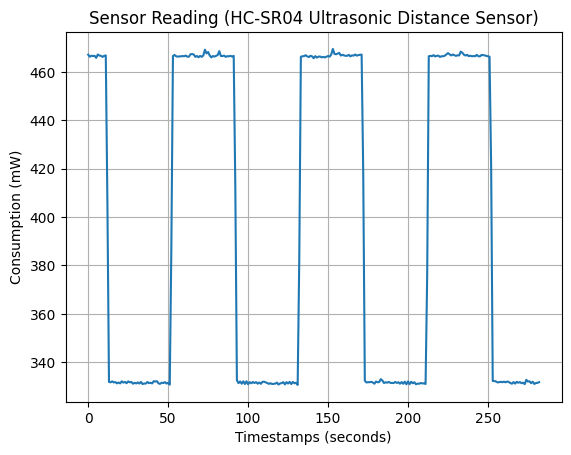

In [5]:
# Plot the sensor reading power consumption plot (sensor_read)
sensor_dataframe.plot(
    xlabel="Timestamps (seconds)",
    ylabel="Consumption (mW)",
    title="Sensor Reading (HC-SR04 Ultrasonic Distance Sensor)",
    kind="line",
    grid=True,
    legend=False,
)

In [6]:
# Sensor Reading Power computation
# Assumption: maximum average value is above 460 (see the plot)
df = sensor_dataframe["Data"]
select_mean = df.loc[(df > 460)].mean()
sensorReadingPower = select_mean.round(2)

print(
    "Average consumption during sensor measurement phase: %.2f mW" % sensorReadingPower
)

Average consumption during sensor measurement phase: 466.74 mW


### Transmission phase

<Axes: title={'center': 'Comparison: Transmission power'}, xlabel='Timestamps (seconds)', ylabel='Consumption (mW)'>

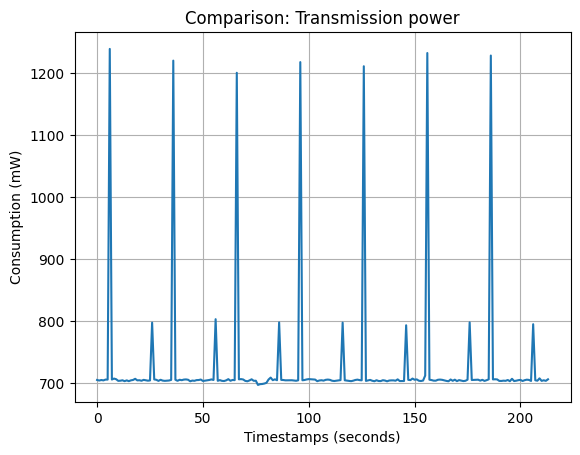

In [7]:
# Comparison of the two peaks in transmission power
transmission_dataframe.plot(
    xlabel="Timestamps (seconds)",
    ylabel="Consumption (mW)",
    title="Comparison: Transmission power",
    kind="line",
    grid=True,
    legend=False,
)

In [8]:
# Transmission Power computation
# Assumption: Values are between 750 and 850 on average (see the plot)
# Also, note the chosen 2 dBm value in the implementation (see the related note in the report)
df = transmission_dataframe["Data"]
select_mean = df.loc[(df > 750) & (df < 850)].mean()
transmissionPower = select_mean.round(2)

print("Average consumption during data transmission phase: %.2f mW" % transmissionPower)

Average consumption during data transmission phase: 797.29 mW


## Estimations

### Time estimation

In [9]:
# Let's now exploit the data processing capabilities to aggregate measurements made in the emulation environment based on their phase
df = timeMisuration_dataframe

select_groupby = df.groupby(["Type of measurement"])["value"].mean()
# The old index is added as a new column to the dataset
df = select_groupby.round(2).reset_index()
df = df.sort_values("value")  # sort by time values, to detect each cycle

# A hashmap containing the final averages
times = pd.Series(data=df["value"].values, index=df["Type of measurement"]).to_dict()

print("Averages: " + str(times).replace(",", "\n"))

Averages: {'wake_up_time': 42707788.0
 'measurement_time_start': 42708960.82
 'measurement_time_end': 42733063.73
 'Wifion_time': 42733380.0
 'sending_time_start': 42917798.09
 'sending_time_end': 42918102.64
 'Wifioff_time': 42953021.73
 'sleep_time': 42955143.73}


In [10]:
# Two parts compose the idle phase:
T_idle1 = (
    times["Wifion_time"] - times["measurement_time_end"]
)  # from the end of the measurement to the boot of Wi-Fi chip
T_idle2 = (
    times["sleep_time"] - times["Wifioff_time"]
)  # from the ending of the Wi-Fi running phase to the deep sleep state begin

T_idle = round(T_idle1 + T_idle2, 2)

print("Average idle phase time: %.2f uS" % T_idle)

Average idle phase time: 2438.27 uS


In [11]:
# Time in which the Wi-Fi chip is on (running), also considering the transmission time
T_wifi = times["Wifioff_time"] - times["Wifion_time"]
T_wifi = round(T_wifi, 2)

print("Average WiFi running phase time: %.2f uS" % T_wifi)

Average WiFi running phase time: 219641.73 uS


In [12]:
# Time during the sensor reading phase (HC-SR04 Ultrasonic Distance Sensor)
T_measure = times["measurement_time_end"] - times["measurement_time_start"]
T_measure = round(T_measure, 2)

print("Average Measurement phase time: %.2f uS" % T_measure)

Average Measurement phase time: 24102.91 uS


In [13]:
# Time during the transmission phase
T_transmission = times["sending_time_end"] - times["sending_time_start"]
T_transmission = round(T_transmission, 2)

print("Average Transmission phase time: %.2f uS" % T_transmission)

Average Transmission phase time: 304.55 uS


In [14]:
# Calculate the active time as the sum of all the states, except the deep sleep state time of course
T_active = (
    T_idle + T_measure + T_wifi
)  # Wi-Fi includes also transmission, otherwise it should be added separately

# Calculate the total time as the sum of the deep sleep average time and the active average time
T_tot = round(T_deepSleep + T_active, 2)

print("Total active time: %.2f uS" % T_active)
print("Total time: %.2f uS" % T_tot)

Total active time: 246182.91 uS
Total time: 15246182.91 uS


### Energy consumption estimation

In [15]:
# Calculate the final average energy consumption for each state
E_idle = idlePower * T_idle
E_measure = sensorReadingPower * T_measure
E_wifi = wifiPower * T_wifi
E_transmission = transmissionPower * T_transmission
E_deepSleep = deepSleepPower * T_deepSleep

print("E_idle: %.2f nJ" % E_idle)
print("E_measure: %.2f nJ" % E_measure)
print("E_wifi: %.2f nJ" % E_wifi)
print("E_transmission: %.2f nJ" % E_transmission)
print("E_deepSleep: %.2f nJ" % E_deepSleep)

E_idle: 758228.82 nJ
E_measure: 11249792.21 nJ
E_wifi: 154676099.10 nJ
E_transmission: 242814.67 nJ
E_deepSleep: 894300000.00 nJ


In [16]:
# Let's now split in two parts: active state (the board is on) and deep sleep state (a board specific sleep-state)
E_active = E_idle + E_measure + E_transmission + E_wifi
E_active = round(E_active, 2)

print("Energy consumption while the board is on (active): %.2f nJ" % E_active)

Energy consumption while the board is on (active): 166926934.81 nJ


In [17]:
# And now, both parts
E_tot = E_active + E_deepSleep
E_tot = E_tot * 10 ** (-6)
E_tot = round(E_tot, 2)

print("Total energy consumed overall: %.2f mJ" % E_tot)

Total energy consumed overall: 1061.23 mJ


In [18]:
# Let's now compute the number of duty cycles that we are able to fit in the energy budget given (battery lifetime, like in the exercise classes)
cycles = milliBattery_capacity / E_tot
cycles = math.floor(cycles)

print("Total number of cycles in the budget: %d cycles" % cycles)

Total number of cycles in the budget: 17206 cycles


In [19]:
# Calculate the number of days that the device can be active with the available battery capacity
seconds = cycles * dutyCycle
days = seconds / (60 * 60 * 24)
days = math.floor(days)

print("Possible activity time is %d seconds = %d days" % (seconds, days))

Possible activity time is 258090 seconds = 2 days


## Results analysys

### Histograms

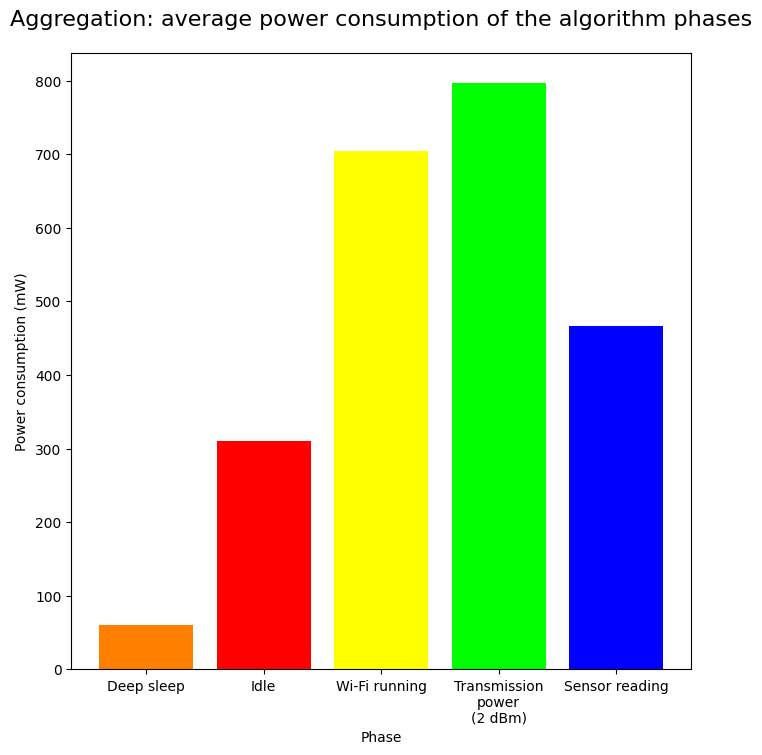

In [20]:
# Commodity hash map for the following plot
power_map = {
    "Deep sleep": deepSleepPower,
    "Idle": idlePower,
    "Wi-Fi running": wifiPower,
    "Transmission\npower\n(2 dBm)": transmissionPower,
    "Sensor reading": sensorReadingPower,
}

colors = [
    (1, 0.5, 0),  # Orange
    (1, 0, 0),  # Red
    (1, 1, 0),  # Yellow
    (0, 1, 0),  # Green
    (0, 0, 1),  # Blue
]

plt.figure(figsize=(8, 8), facecolor="white")
# labels, data to use and related colors
plt.bar(list(power_map.keys()), list(power_map.values()), color=colors)
plt.xlabel("Phase")
plt.ylabel("Power consumption (mW)")
plt.title(
    "Aggregation: average power consumption of the algorithm phases",
    fontsize=16,
    pad=20,
)

plt.show()

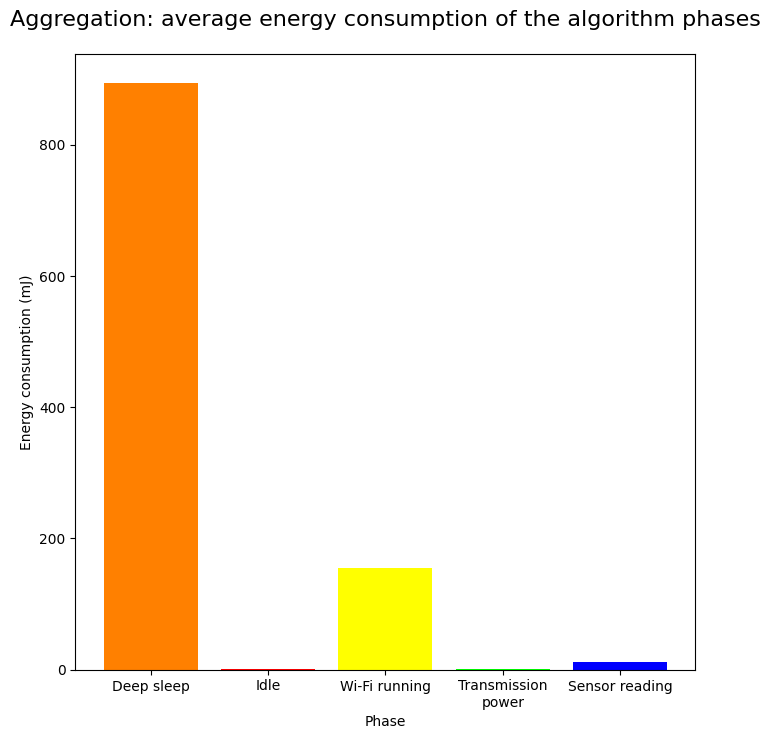

In [21]:
# Commodity hash map for the following plot
# Consumed energy is converted in mJ
power_map = {
    "Deep sleep": E_deepSleep * 10 ** (-6),
    "Idle": E_idle * 10 ** (-6),
    "Wi-Fi running": E_wifi * 10 ** (-6),
    "Transmission\npower": E_transmission * 10 ** (-6),
    "Sensor reading": E_measure * 10 ** (-6),
}

colors = [
    (1, 0.5, 0),  # Orange
    (1, 0, 0),  # Red
    (1, 1, 0),  # Yellow
    (0, 1, 0),  # Green
    (0, 0, 1),  # Blue
]

plt.figure(figsize=(8, 8), facecolor="white")
# labels, data to use and related colors
plt.bar(list(power_map.keys()), list(power_map.values()), color=colors)
plt.xlabel("Phase")
plt.ylabel("Energy consumption (mJ)")
plt.title(
    "Aggregation: average energy consumption of the algorithm phases",
    fontsize=16,
    pad=20,
)

plt.show()

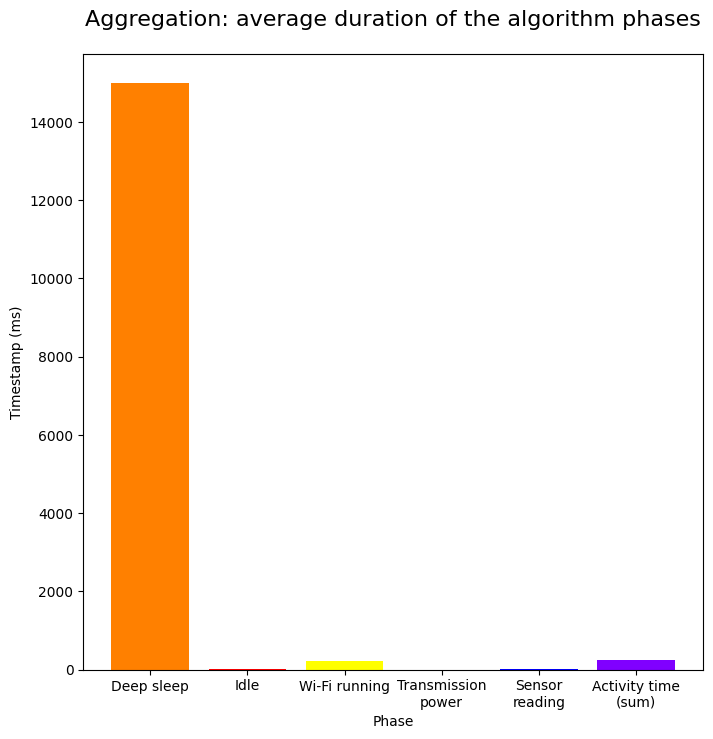

In [22]:
# Commodity hash map for the following plot
# Time measurements are converted in ms
times_map = {
    "Deep sleep": T_deepSleep * 10 ** (-3),
    "Idle": T_idle * 10 ** (-3),
    "Wi-Fi running": T_wifi * 10 ** (-3),
    "Transmission\npower": T_transmission * 10 ** (-3),
    "Sensor\nreading": T_measure * 10 ** (-3),
    "Activity time\n(sum)": T_active * 10 ** (-3),
}

colors = [
    (1, 0.5, 0),  # Orange
    (1, 0, 0),  # Red
    (1, 1, 0),  # Yellow
    (0, 1, 0),  # Green
    (0, 0, 1),  # Blue
    (0.5, 0, 1),  # Violet
]

plt.figure(figsize=(8, 8), facecolor="white")
# labels, data to use and related colors
plt.bar(list(times_map.keys()), list(times_map.values()), color=colors)

plt.xlabel("Phase")
plt.ylabel("Timestamp (ms)")
plt.title("Aggregation: average duration of the algorithm phases", fontsize=16, pad=20)

plt.show()

## Improvements proposals section (report)

### A lower duty cycle
In the following, a 60 seconds duty-cycle is considered

Total number of cycles in the budget: 4876 cycles
Possible activity time is 292560 seconds = 3 days


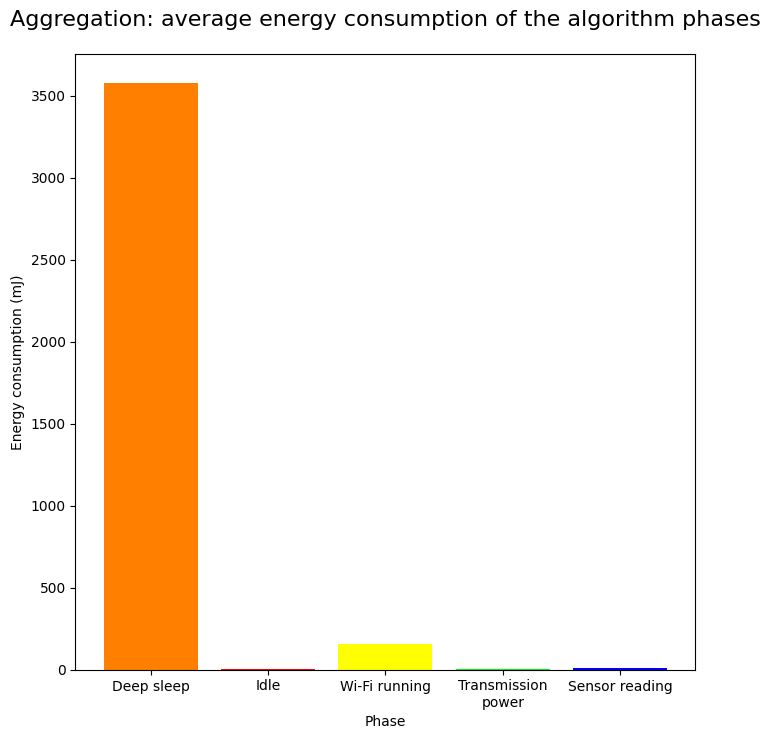

In [23]:
dutyCycle = 60  # Modified for improvements proposals in the report document
dutyCycle_micros = dutyCycle * 10**6

T_deepSleep = dutyCycle_micros  # Fixed time for deep sleep (a first approximation to the problem, see considerations in the report for more details)

# Calculate the final average energy consumption for each state
E_deepSleep = deepSleepPower * T_deepSleep

# And now, both parts
E_tot = E_active + E_deepSleep
E_tot = E_tot * 10 ** (-6)
E_tot = round(E_tot, 2)

# Let's now compute the number of duty cycles that we are able to fit in the energy budget given (battery lifetime, like in the exercise classes)
cycles = milliBattery_capacity / E_tot
cycles = math.floor(cycles)

print("Total number of cycles in the budget: %d cycles" % cycles)

# Calculate the number of days that the device can be active with the available battery capacity
seconds = cycles * dutyCycle
days = seconds / (60 * 60 * 24)
days = math.floor(days)

print("Possible activity time is %d seconds = %d days" % (seconds, days))

# And let's recompute the energy consumption plot

# Commodity hash map for the following plot
# Consumed energy is converted in mJ
power_map = {
    "Deep sleep": E_deepSleep * 10 ** (-6),
    "Idle": E_idle * 10 ** (-6),
    "Wi-Fi running": E_wifi * 10 ** (-6),
    "Transmission\npower": E_transmission * 10 ** (-6),
    "Sensor reading": E_measure * 10 ** (-6),
}

colors = [
    (1, 0.5, 0),  # Orange
    (1, 0, 0),  # Red
    (1, 1, 0),  # Yellow
    (0, 1, 0),  # Green
    (0, 0, 1),  # Blue
]

plt.figure(figsize=(8, 8), facecolor="white")
# labels, data to use and related colors
plt.bar(list(power_map.keys()), list(power_map.values()), color=colors)
plt.xlabel("Phase")
plt.ylabel("Energy consumption (mJ)")
plt.title(
    "Aggregation: average energy consumption of the algorithm phases",
    fontsize=16,
    pad=20,
)

plt.show()

### A lower duty cycle
In the following, a 180 seconds duty-cycle is considered

Total number of cycles in the budget: 1675 cycles
Possible activity time is 301500 seconds = 3 days


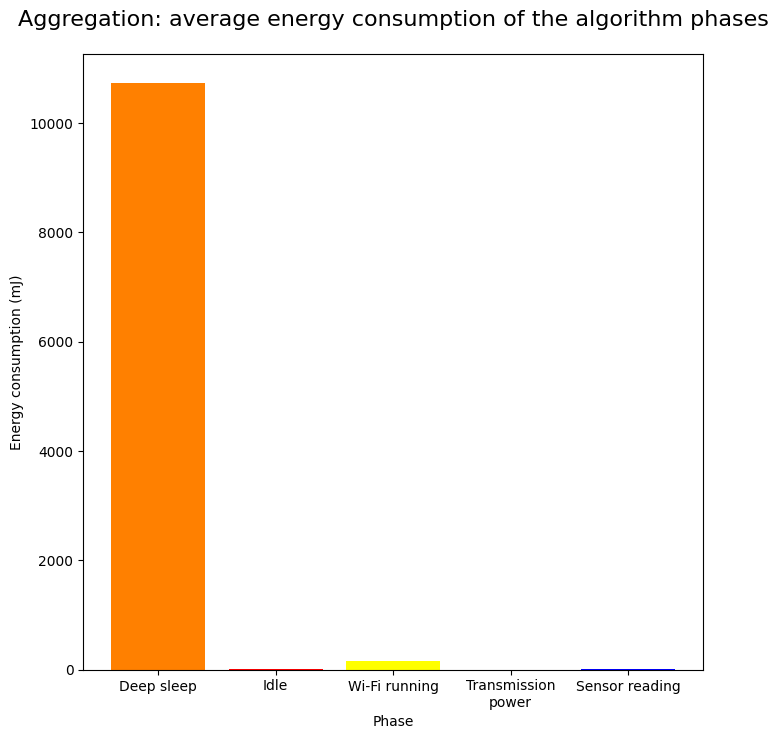

In [24]:
dutyCycle = 180  # Modified for improvements proposals in the report document
dutyCycle_micros = dutyCycle * 10**6

T_deepSleep = dutyCycle_micros  # Fixed time for deep sleep (a first approximation to the problem, see considerations in the report for more details)

# Calculate the final average energy consumption for each state
E_deepSleep = deepSleepPower * T_deepSleep

# And now, both parts
E_tot = E_active + E_deepSleep
E_tot = E_tot * 10 ** (-6)
E_tot = round(E_tot, 2)

# Let's now compute the number of duty cycles that we are able to fit in the energy budget given (battery lifetime, like in the exercise classes)
cycles = milliBattery_capacity / E_tot
cycles = math.floor(cycles)

print("Total number of cycles in the budget: %d cycles" % cycles)

# Calculate the number of days that the device can be active with the available battery capacity
seconds = cycles * dutyCycle
days = seconds / (60 * 60 * 24)
days = math.floor(days)

print("Possible activity time is %d seconds = %d days" % (seconds, days))

# And let's recompute the energy consumption plot

# Commodity hash map for the following plot
# Consumed energy is converted in mJ
power_map = {
    "Deep sleep": E_deepSleep * 10 ** (-6),
    "Idle": E_idle * 10 ** (-6),
    "Wi-Fi running": E_wifi * 10 ** (-6),
    "Transmission\npower": E_transmission * 10 ** (-6),
    "Sensor reading": E_measure * 10 ** (-6),
}

colors = [
    (1, 0.5, 0),  # Orange
    (1, 0, 0),  # Red
    (1, 1, 0),  # Yellow
    (0, 1, 0),  # Green
    (0, 0, 1),  # Blue
]

plt.figure(figsize=(8, 8), facecolor="white")
# labels, data to use and related colors
plt.bar(list(power_map.keys()), list(power_map.values()), color=colors)
plt.xlabel("Phase")
plt.ylabel("Energy consumption (mJ)")
plt.title(
    "Aggregation: average energy consumption of the algorithm phases",
    fontsize=16,
    pad=20,
)

plt.show()